<center><img src='../../img/ai4eo_logos.jpg' alt='Logos AI4EO MOOC' width='80%'></img></center>

<hr>

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1183058"><< Back to FutureLearn</a><br>

# ML4Floods - Train a flood extent segmentation model using the WorldFloods dataset

<i>by Sam Budd and Gonzalo Mateo-Garcia, Frontier Development Lab</i>

<hr>

## Watch the video tutorial

In [1]:
from IPython.display import HTML
HTML('<div align="center"><iframe src="https://player.vimeo.com/video/510225048" width="640" height="360" frameborder="0" allow="autoplay; fullscreen; picture-in-picture" allowfullscreen align="middle"></iframe></div>')     

<br>

<hr>

## Introduction

ML4Floods is an end-to-end Machine Learning pipline for flood extent estimation: from data preprocessing, model training, model deployment to visualization. This workflow shows you how you can train a flood extent segmentation model using the [WorldFloods](https://www.nature.com/articles/s41598-021-86650-z) dataset in order to produce flood masks. 

## Machine Learning algorithm

This example shows you how you can train a `convolutional neural network` (CNN) architecture for flood segmentation. The notebook makes use of the [ml4floods](https://github.com/spaceml-org/ml4floods) Python library, which offers you three pre-defined CNN architectures: `simple_cnn`, `unet` and `linear`.

The aimed output of the model are images classified in three classes: `land`, `water/flood` and `clouds`.

## Data

The model is trained based on the [WorldFloods dataset](https://www.nature.com/articles/s41598-021-86650-z). WorldFloods contains 422 flood extent maps created by photo-interpretation either manually or semi-automatically, where a human validated the machine-generated maps. The 422 flood extent maps are part of 119 flood events that occured between November 2015 and March 2019.

A flood extent map is a vector layer (shapefile) that consists of polygons indicating the presence of water. Each vector layer is based on a satellite image and has been assigned a date and classified to a specific flood event.

The flood extent maps were sourced from three organisations:
* the [Copernicus Emergency Management Service (Copernicus EMS)](https://emergency.copernicus.eu/)
* the flood portal of [UNOSAT](http://floods.unosat.org/geoportal/catalog/main/home.page)
* the [Global Flood Inundation Map Repository (GLOFIMR)](https://sdml.ua.edu/glofimr/)

## Further resources

* [ML4Floods Github repository](https://github.com/spaceml-org/ml4floods)
* [ML4Floods - An ecosystem of data, models and code piplines to tackle flooding with Machine Learning](http://trillium.tech/ml4floods/content/intro/introduction.html)
* [Towards global flood mapping  onboard low cost satellites with machine learning](https://www.nature.com/articles/s41598-021-86650-z)


<hr>

## Notebook outline


* [1 - Setup environment and configurations](#env_setup_6f)
* [2 - Setup the Dataloader to download the data and inspect the training data](#dataloader_6f)
* [3 - Setup of the Convolutional Neural Network model](#model_setup_6f)
* [4 - Setup lightning callbacks](#setup_callbacks_6f)
* [*5 - Optional: Model training (fitting)*](#model_fitting_6f)
* [6 - Evaluation of model performance](#evaluation_6f)
* [7 - Show results for each flood event in the validation dataset](#validate_model_6f)
* [*8 - Optional: Save the trained model*](#save_model_6f)

<hr>

#### Import libraries

In [5]:
import sys, os
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pkg_resources

from pytorch_lightning import seed_everything
from pytorch_lightning.utilities.cloud_io import atomic_save
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.cloud_io import load
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from ml4floods.models.config_setup import get_default_config
from ml4floods.models.dataset_setup import get_dataset
from ml4floods.models import worldfloods_model
from ml4floods.models.model_setup import get_model
from ml4floods.models.model_setup import get_model_inference_function
from ml4floods.models.utils import metrics
from ml4floods.models.config_setup import save_json

import pickle

<hr>

## <a id='env_setup_6f'></a>1. Setup environment and configurations

The first step is to load the configuration file from the [ml4floods](https://github.com/spaceml-org/ml4floods) package. You can use the library `pkg_resources` to retrieve the file path to the configuration file. The configuration file has the name `worldfloods_template.json` and can be found under `models/configurations/`.

The ml4floods function `get_default_config` loads the configuration file. You see that the file is in principle a Python dictionary consisting of different data and model parameters. 

**Note**: This workflow makes use of the [ml4floods](https://github.com/spaceml-org/ml4floods) Python package. The package is already installed. If you want to reproduce the example on your local machine, you can install the package with the following command:
> `pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods`

In [3]:
config_fp = pkg_resources.resource_filename("ml4floods","models/configurations/worldfloods_template.json")
print(config_fp + '\n')

config = get_default_config(config_fp)

/opt/conda/envs/mooc_ai4eo/lib/python3.8/site-packages/ml4floods/models/configurations/worldfloods_template.json

Loaded Config for experiment:  worldfloods_demo_test
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4cc_data_lake',
                       'channel_configuration': 'all',
                       'download': {'test': True, 'train': True, 'val': True},
                       'filter_windows': {   'apply': False,
                                             'threshold_clouds': 0.5,
                                             'version': 'v1'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 4,
                       'path_to_splits': 'worldfloods',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json',
   

<br>

Since we want to have unique experiment outcomes, the next step is to overwrite the default folder where to store the experiments (`worldfloods_demo_test` and set the folder path to `training_demo`.

In [4]:
config.experiment_name = 'training_demo'

<br>

For reproducibility, it is advisable to initialise a random number generator that can help to reproduce results. You can use the function `seed_everything()` from the `pytorch_lightning` library. You can use the seed number provided in the configuration file or you can set your own number.

In [5]:
seed_everything(config.seed)

Global seed set to 12


12

<br>

## <a id='dataloader_6f'></a>2. Setup the Dataloader to download the data and inspect the training data

The next step shows you how you can download data from the `WorldFloods` dataset with the help of the `ml4floods` library. You will not need to execute the step below to follow the next steps in the workflow, as the data has already been downloaded and is available in the `worldfloods_v1_sample` folder.

You can modify the data parameters `data_params` of the configuration dictionary as follows:
* `batch_size`: control this depending on the space on your GPU
* `loader_typ`: can be 'local', which assumes that the images are available locally or 'bucket', which loads images directly from a Google cloud storage bucket specified. To load images from the Google bucket, the 'GOOGLE_APPLICATION_CREDENTIALS' env variable must be set. 
* `num_workers`: number of multiple processes running at the same time
* `path_to_split`: local folder to store the data. If 'loader_type=local' and the data is not found, data download is triggered and data is stored to the assigned folder
* `train_test_split_file`: The full WorldFloods dataset is 264 GB. For training purposes, you can use the `train_test_split_file` which only downloads a subset (13 GB) of the training, validation and test data sets

With the `download` key of the configuration file, you can also specify which data types shall be downloaded: `train`, `val` and / or `test`.

In [6]:
config.data_params.batch_size = 16
config.data_params.loader_type = 'local'
config.data_params.num_workers = 0
config.data_params.path_to_splits = "worldfloods_v1_sample"
config.data_params.train_test_split_file = "2_PROD/2_Mart/worldfloods_v1_0/train_test_split_sample.json"

config.data_params["download"] = {"train": True, "val": True, "test": False}

<br>

Once the arguments above have been specified, you can then continue to load the dataset by using the function `get_dataset()` from the `ml4floods` package. If the dataset is not downloaded yet, the function triggers the download. If the data is already available locally, you get an overview of how many images are available for training and validation.

In [7]:
%%time
dataset = get_dataset(config.data_params)

Using local dataset for this run
Skip download test
train 6298  tiles
val 1284  tiles
test 0  tiles
CPU times: user 197 ms, sys: 28.6 ms, total: 226 ms
Wall time: 35 s


<br>

The `dataset` object is a [pytorch_lightning DataModule object](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.core.datamodule.html). This object has the *WorldFloods* `training`, `validation` and `test` datasets as attributes (`dataset.train_dataset`, `dataset.val_dataset` and `dataset.test_dataset`). 

You can load e.g. the training data and you can see that the worldfloods dataset consists of 6298 items for training and 1284 for validation.


In [8]:
print(len(dataset.train_dataset))
print(len(dataset.val_dataset))

6298
1284


<br>

You can load the specific datasets by creating a `pytorch DataLoader` object with the help of the functions `train_dataloader()`, `val_dataloader()` or `test_dataloader()` respectively.
The code below creates first a `pytorch DataLoader` object with the training dataset and selects then a random `batch` of the dataset, depending on the `batch_size` defined in the configuration file. Each item consists of two items, an `image` and a `mask`.

If you check the dimensions of the two items with the function `shape()`, you see the following dimension specifications:
* `image`: `[16, 13, 256, 256]`
* `batch`: `[16, 1, 256, 256]`

13 is the number of bands available in a Sentinel-2 image.

In [9]:
train_dl = dataset.train_dataloader()

train_dl_iter = iter(train_dl)
batch = next(train_dl_iter)

batch["image"].shape, batch["mask"].shape

(torch.Size([16, 13, 256, 256]), torch.Size([16, 1, 256, 256]))

<br>

Now, you can inspect some of the training images. You can use the function `plot_batch` from the worldfloods_model module. The function plots a given number (in the case below it is six) of images in a row. Below, you will see the following three rows:
* `first row`: shows six training images as true-color composites
* `second row`: shows six training images as false-color composites highlighting specifically water
* `third row`: land - water - cloud masks of the respective images

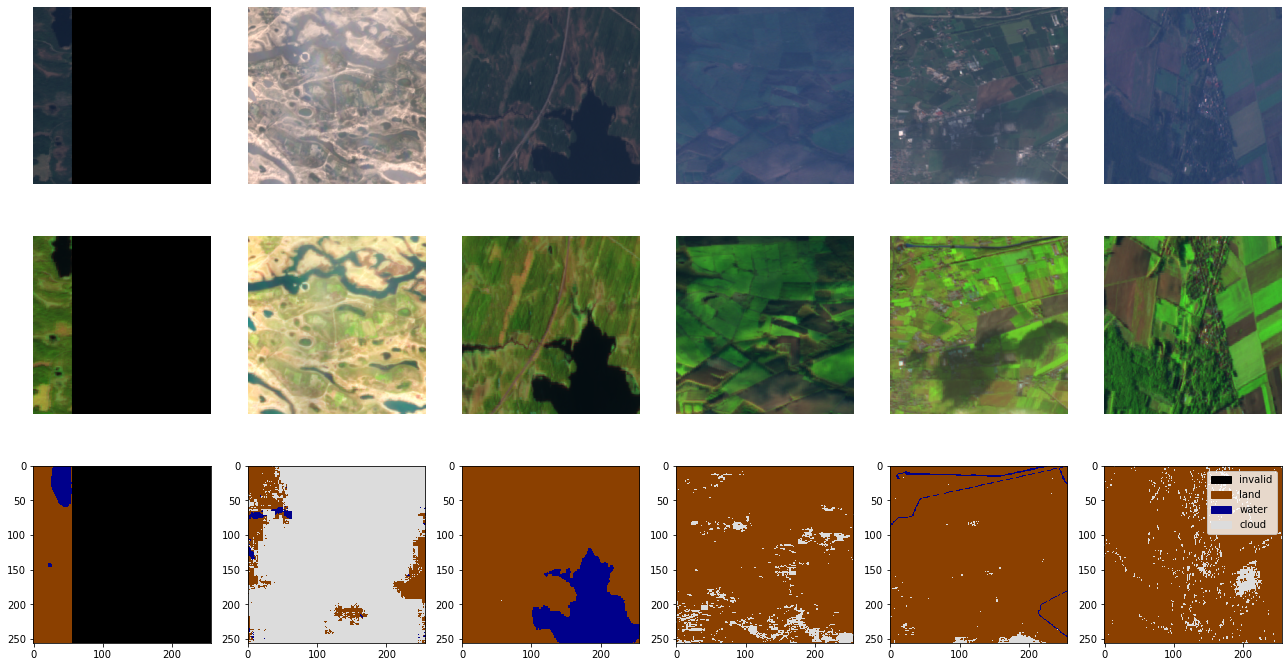

In [10]:
n_images=6
fig, axs = plt.subplots(3,n_images, figsize=(18,10),tight_layout=True)

worldfloods_model.plot_batch(batch["image"][:n_images],axs=axs[0],max_clip_val=3500.)
worldfloods_model.plot_batch(batch["image"][:n_images],bands_show=["B11","B8", "B4"],
                             axs=axs[1],max_clip_val=4500.)
worldfloods_model.plot_batch_output_v1(batch["mask"][:n_images, 0],axs=axs[2], show_axis=True)

<br>

## <a id='model_setup_6f'></a>3. Setup of the Convolutional Neural Network model

The configuration file `config` contains `model_params`, which is a group of parameters relevant for setting up and training the model. With `config.model_params`, you can inspect the parameters currently specified. 

In [11]:
config.model_params

{'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart',
 'model_version': 'v1',
 'hyperparameters': {'max_tile_size': 256,
  'metric_monitor': 'val_dice_loss',
  'channel_configuration': 'all',
  'label_names': ['land', 'water', 'cloud'],
  'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
  'model_type': 'linear',
  'num_classes': 3,
  'max_epochs': 10,
  'val_every': 1,
  'lr': 0.0001,
  'lr_decay': 0.5,
  'lr_patience': 2,
  'early_stopping_patience': 4,
  'num_channels': 13},
 'train': True,
 'test': True}

<br>

Let us change the following parameters:
* `model_folder`: specify a local folder name
* `test`: set to False, as we want to train the model from scratch
* `train`: True specifies that you want to train a model from scratch
* `hyperparameters.model_type`: set the model to 'simplecnn', which will train a simple convolutional neural network
* `hyperparameters.max_epochs`: set the number of epochs (training cycles)

In [12]:
config.model_params.model_folder = "models" 
os.makedirs("models", exist_ok=True)

config.model_params.test = False
config.model_params.train = True

config.model_params.hyperparameters.model_type = "simplecnn" # Currently implemented: simplecnn, unet, linear
config.model_params.hyperparameters.max_epochs = 4 # train for maximum 4 epochs


<br>

Additionally, you want to set the `gpus` parameter to None, as the training platform does not offer any GPU computing support.

In [13]:
config.gpus = None

<br>

The function `get_model()` allows you to load a pre-configured `Convolutional Neural Network` architecture. The architecture of the `simplecnn` architecture consists of a `Sequential` model with the following layer architecture:
* 4 `Conv2d (convolutional) layers` with a `ReLU` activation in between
* a final `Conv2d (convolutional) layer` that converts 128 bands to 3 classes

Alternative model architectures available in the [ml4floods](https://github.com/spaceml-org/ml4floods) library are `unet` and `linear`. See [here](https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-021-86650-z/MediaObjects/41598_2021_86650_MOESM1_ESM.pdf) the available model architectures described in detail.

**Note**: `ReLU` introduces non-linearities. 


In [14]:
model = get_model(config.model_params)
model

WorldFloodsModel(
  (network): SimpleCNN(
    (conv): Sequential(
      (0): Sequential(
        (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

<br>

#### *Optional: fine-tune the model*

Training the model from scratch takes quite a long time. Instead you could load the weights of a pre-trained model and *fine-tune* the model with the data. For this it is enough to train the model with only very few epochs.

In [15]:
from pytorch_lightning.utilities.cloud_io import load

weights_pretrained_model_path = "gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart/WFV1_scnn20/model.pt"
model.load_state_dict(load(weights_pretrained_model_path))

<All keys matched successfully>

<br>

## <a id='setup_callbacks_6f'></a>4. Setup lightning callbacks

The next step is to implement `callbacks` in order to better define the behaviour during the training:
* `ModelCheckpoint`: the ModelCheckpoint callback saves the best performing model checkpoint to the locally defined folder
* `EarlyStopping`: the EarlyStopping callback stops the training process if there is no performance improvement after ten epochs from the last checkpoint

In [ ]:
experiment_path = f"{config.model_params.model_folder}/{config.experiment_name}"

checkpoint_callback = ModelCheckpoint(
    dirpath=f"{experiment_path}/checkpoint",
    save_top_k=True,
    verbose=True,
    monitor='val_dice_loss',
    mode='min'
)

early_stop_callback = EarlyStopping(
    monitor='val_dice_loss',
    patience=10,
    strict=False,
    verbose=False,
    mode='min'
)

callbacks = [checkpoint_callback, early_stop_callback]

print(f"The trained model will be stored in {config.model_params.model_folder}/{config.experiment_name}")

<br>

## <a id='model_fitting_6f'></a>*5. Optional: Model training (fitting)*

> <i>**Note:** the training process may take hours on a resource constrained environment. For this reason, you can inspect the code below to see what is required for the training process. However, you can continue to step [6. Evaluation model performance](#evaluation_6f), where you will be guided through the principles of evaluating the performance of a trained model.</i>

For model training (fitting), you can make use of the [Pytorch Lightning Trainer](https://pytorch-lightning.readthedocs.io/en/0.7.5/trainer.html), which is an abstraction that automates the training of the model. The first step is to define the Trainer, which in principle configures the parameters that are required for training. You can provide the Trainer the defined `callbacks` and some of the defined `hyperparameters` of the configuration file.

See [here](https://pytorch-lightning.readthedocs.io/en/0.7.5/trainer.html#trainer-flags) for a full list of Trainer flags.

In [17]:
trainer = Trainer(
    fast_dev_run=False,
    callbacks=callbacks,
    logger=None,
    default_root_dir=f"{config.model_params.model_folder}/{config.experiment_name}",
    accumulate_grad_batches=1,
    gradient_clip_val=0.0,
    auto_lr_find=False,
    benchmark=False,
    distributed_backend=None,
    gpus=config.gpus,
    max_epochs=config.model_params.hyperparameters.max_epochs,
    check_val_every_n_epoch=config.model_params.hyperparameters.val_every,
    log_gpu_memory=None,
    resume_from_checkpoint=None
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


<br>

Once the [Pytorch Lightning Trainer](https://pytorch-lightning.readthedocs.io/en/0.7.5/trainer.html) has been setup, you can train (fit) the model. You can use the function `fit()` to train the model with the dataset loaded. 

In [ ]:
trainer.fit(model, dataset)

<br>

## <a id='evaluation_6f'></a>6. Evaluation of model performance

After the model has been trained, you are interested in how the model has performed. The next steps will guide you through the evaluation process of a pre-trained model that is part of the [ml4floods](https://github.com/spaceml-org/ml4floods) library.

The first step is to load the pre-trained model. You can load the weights of a pre-trained model from the [ml4floods](https://github.com/spaceml-org/ml4floods) package with the function `model.load_state_dict()`.

In [17]:
weights_pretrained_model_path = "gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart/WFV1_scnn20/model.pt"
model.load_state_dict(load(weights_pretrained_model_path))

<All keys matched successfully>

<br>

A Machine Learning model provides `logits` as output, which are non-normalized predictions of the model. In multi-class classification problems, `logits` are usually the input for the `softmax` function, which converts logits to pixel-wise probabilities. 

You can load the logits directly from the loaded model. In the code below, you load the logits of the 16 randomly selected images of the `batch` object.

In [18]:
logits = model(batch["image"].to(model.device))
print(f"Shape of logits: {logits.shape}")

Shape of logits: torch.Size([16, 3, 256, 256])


<br>

The next step is then to convert the logits into probabilites. The function `softmax` from Pytorch converts the logits into probabilities, where each image has three channels, one for each class: `1 - land`, `2 - water` and `3 - cloud`. The sum of the probabilites of all classes is 1. 

The class with the highest probability is the predicted class and is eventually set as the predicted class. You can choose the final predicted class with the function `argmax`. As a result, the shape of the `prediction` object decreases from 16 images with each 3 channels to only 16 images with one value.

In [19]:
probs = torch.softmax(logits, dim=1)
print(f"Shape of probs: {probs.shape}")

prediction = torch.argmax(probs, dim=1).long().cpu()
print(f"Shape of prediction: {prediction.shape}")

Shape of probs: torch.Size([16, 3, 256, 256])
Shape of prediction: torch.Size([16, 256, 256])


<br>

Let us now include to the plotted images above also a row that shows the predictions of the model. You can use again the function `plot_batch` from the worldfloods_model module. The function plots a given number (in the case below it is six) of images in a row. Below, you will see four rows:
* `first row`: shows six training images as true-color composites
* `second row`: shows six training images as false-color composites highlighting specifically water
* `third row`: land - water - cloud masks of the respective images
* `fourth row`: predictions of the land - water - cloud classes

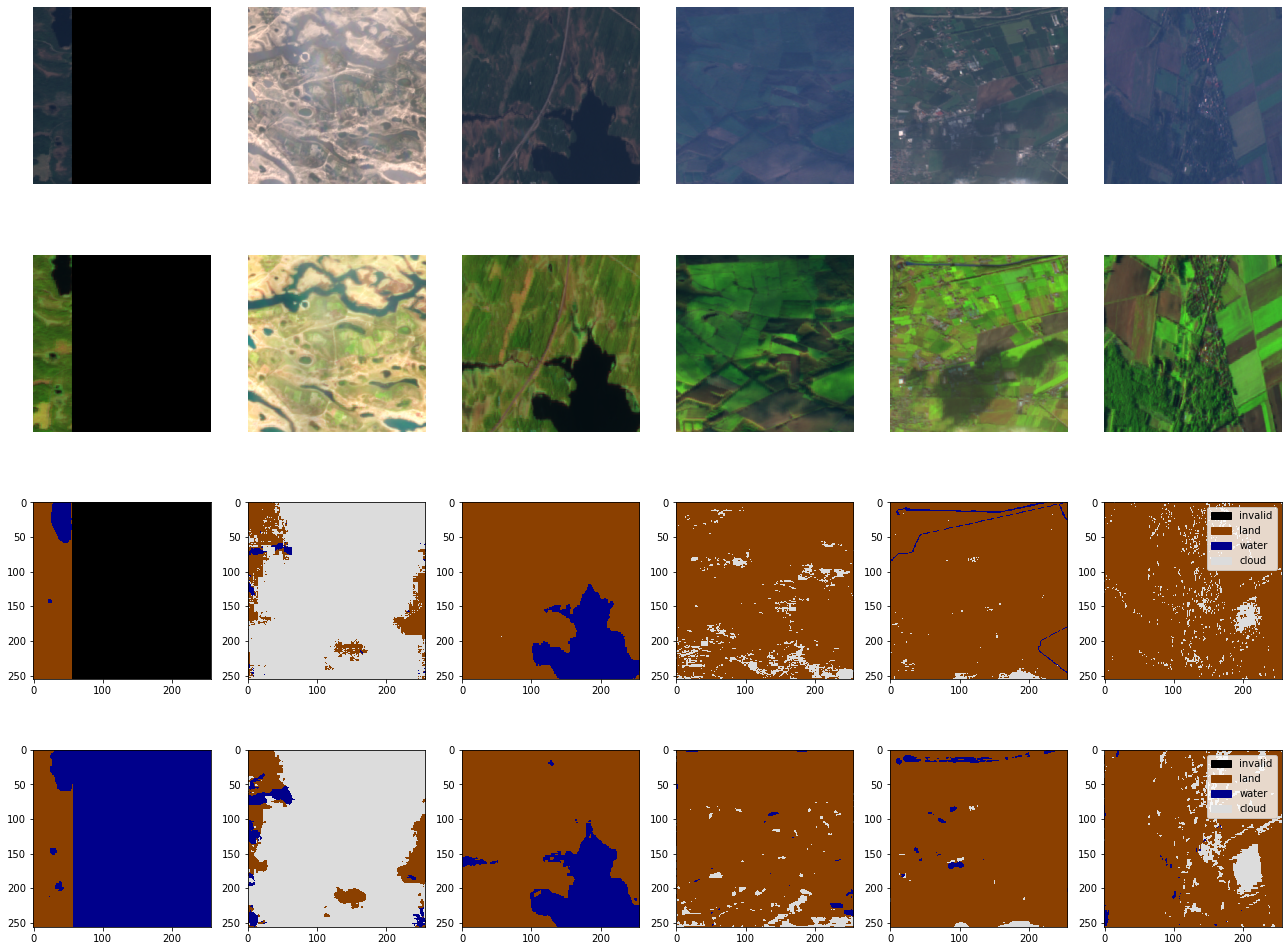

In [20]:
n_images=6
fig, axs = plt.subplots(4, n_images, figsize=(18,14),tight_layout=True)
worldfloods_model.plot_batch(batch["image"][:n_images],axs=axs[0],max_clip_val=3500.)
worldfloods_model.plot_batch(batch["image"][:n_images],bands_show=["B11","B8", "B4"],
                             axs=axs[1],max_clip_val=4500.)
worldfloods_model.plot_batch_output_v1(batch["mask"][:n_images, 0],axs=axs[2], show_axis=True)
worldfloods_model.plot_batch_output_v1(prediction[:n_images] + 1,axs=axs[3], show_axis=True)

for ax in axs.ravel():
    ax.grid(False)

<br>

The next step is to compute some performance metrics that  help you to better assess the accuracy of the model. 

The function `compute_metrics` from the [ml4floods](https://github.com/spaceml-org/ml4floods) library computes three common performance metrics:
* `Confusion matrix`: is a table that describes the performance of a classification model on a set of test data
* `Precision recall curve`: shows the tradeoff between **precision** and **recall**. A high area under the curve represents both high **recall** and high **precision**, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.
* `ROC (received operating characteristic) curve`: shows the performance of a classification model at all classification thresholds

The function takes the following inputs, which you best define separately:
* `dl`: pytorch Dataloader object of the validation data
* `inference_function`: loaded inference function, which allows to run the inference process on larger images
* `thresholds_water`: classification thresholds defined for water

In [21]:
config["model_params"]["max_tile_size"] = 256
inference_function = get_model_inference_function(model, config, apply_normalization=False, 
                                                  activation="softmax")

dl = dataset.val_dataloader() # pytorch Dataloader

thresholds_water = [0,1e-3,1e-2]+np.arange(0.5,.96,.05).tolist() + [.99,.995,.999]

Getting model inference function
Max tile size: 256


<br>

Now, you can compute the metrics and plot them with the function `metrics.plot_metrics()`.

> **Note:** The computation of the metrics might take quite a long time. Hence, below you can load a pickle file with pre-computed metrics. If you wish to compute the metrics, you can uncomment the first lines of code in the cell below.

In [ ]:
#mets = metrics.compute_metrics(dl,inference_function, thresholds_water=thresholds_water, plot=False)

#f = open('mets.pckl', 'wb')
#pickle.dump(mets, f)
#f.close()

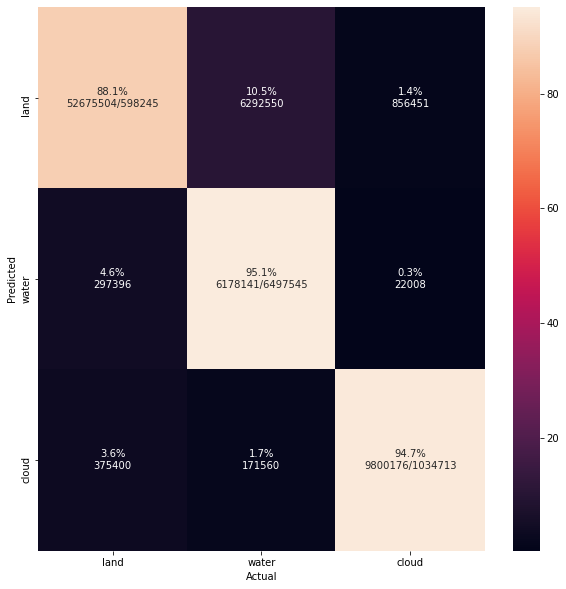

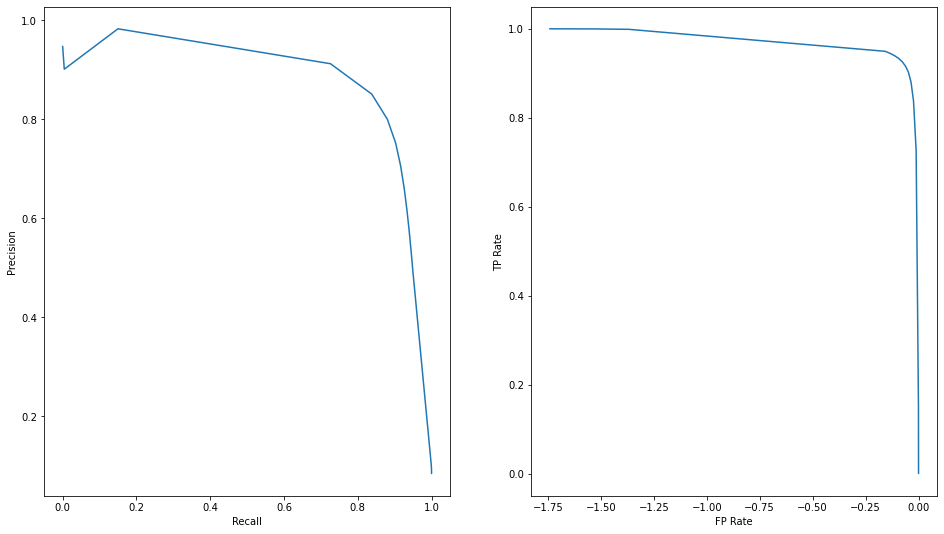

Per Class IOU {
    "cloud": 0.8730206283053926,
    "land": 0.8707083312692225,
    "water": 0.47664754230856143
}


In [6]:
f = open('mets.pckl', 'rb')
mets = pickle.load(f)
f.close()

label_names = ["land", "water", "cloud"]
metrics.plot_metrics(mets, label_names)

<br>

## <a id='validate_model_6f'></a>7. Show results for each flood event in the validation dataset

Another performance evaluation is to calculate for each of the validation data files the following metrics:
* `recall per class`: number of correctly classified pixels divided by the number of classified pixels that should have been returned
* `Intersection over Union (IoU) per class`: is the overlap divided by union. If the prediction is 100% correct, IoU = 1. The lower the IoU, the worse the prediction result.

The code below results in a tables with six rows indicating the number of validation files and six columns, indicating the six calculated metrics (Recall and IoU for each class).

In [24]:
if hasattr(dl.dataset, "image_files"):
    cems_code = [os.path.basename(f).split("_")[0] for f in dl.dataset.image_files]
else:
    cems_code = [os.path.basename(f.file_name).split("_")[0] for f in dl.dataset.list_of_windows]

iou_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_iou,
                                                    label_names=[f"IoU_{l}"for l in ["land", "water", "cloud"]]))

recall_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_recall,
                                                       label_names=[f"Recall_{l}"for l in ["land", "water", "cloud"]]))

join_data_per_code = pd.merge(recall_per_code,iou_per_code,on="code")
join_data_per_code = join_data_per_code.set_index("code")
join_data_per_code = join_data_per_code*100
print(f"Mean values across flood events: {join_data_per_code.mean(axis=0).to_dict()}")
join_data_per_code

Mean values across flood events: {'Recall_land': 87.9493118279229, 'Recall_water': 91.39979038501788, 'Recall_cloud': 82.17021425242872, 'IoU_land': 86.81751901359586, 'IoU_water': 46.51690066958454, 'IoU_cloud': 74.03323867025377}


,Recall_land,Recall_water,Recall_cloud,IoU_land,IoU_water,IoU_cloud
code,,,,,,
EMSR271,62.560875,98.476078,94.030277,62.426847,16.714910,85.662395
EMSR279,78.448898,89.412425,94.812902,76.636507,21.507198,87.136735
EMSR280,96.853240,96.137739,81.703026,96.281934,79.701112,68.288379
EMSR287,97.706265,88.067559,35.434007,97.361856,47.429321,22.976099
RS2,94.031983,92.450334,92.311036,91.686438,52.559740,88.479503
ST1,98.094609,83.854607,94.730037,96.511531,61.189125,91.656321


<br>

## <a id='save_model_6f'></a>*8. Optional: Save the trained model*

In case you have a trained model, you can save it. You can use the function `atomic_save()` from the pytorch_lightning library, which will save the model itself. The function `save_json()` from the [ml4floods](https://github.com/spaceml-org/ml4floods) library allows you to additionally save the configuration file of the model.

In [25]:
# Save in the cloud and in the wandb logger save dir
atomic_save(model.state_dict(), f"{experiment_path}/model.pt")

# Save cofig file in experiment_path
config_file_path = f"{experiment_path}/config.json"
save_json(config, config_file_path)

<br>

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1183058"><< Back to FutureLearn</a><br>

<hr>

<img src='../../img/copernicus_logo.png' alt='Copernicus logo' align='left' width='20%'></img>

Course developed for [EUMETSAT](https://www.eumetsat.int/), [ECMWF](https://www.ecmwf.int/) and [Mercator Ocean International](https://www.mercator-ocean.fr/en/) in support of the [EU’s Copernicus Programme](https://www.copernicus.eu/en) and the [WEkEO platform](https://wekeo.eu/).
